# Is it possible to predict grades with Machine Learning?

The code in this file was used to understand how final grade is correlated with a couple of other features with the help of data from two portugese secondary schools. The file includes, but is not limited to: Data cleaning, PCA, Feature selection, Decision tree classification, Lasso regresion, linear regression, K-means clustering, DBSCAN, and evaluations.

Information about the dataset used for this project can be found att Kaggle through this link: https://www.kaggle.com/datasets/barkhaverma/student-performance.

In [1]:
# LIBRARIES #
import pandas as pd
import numpy as np
import matplotlib as plt
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import io
import sklearn
import graphviz

import sklearn.metrics  as metrics
import sklearn.cluster as cluster
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, KFold, cross_val_score, GridSearchCV
from sklearn.feature_selection import SelectFromModel, SelectKBest, f_classif, mutual_info_classif
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.tree import export_graphviz
from sklearn.pipeline import make_pipeline
from graphviz import Source
from sklearn.cluster import DBSCAN
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import silhouette_score

%matplotlib inline

In [2]:
# READ CSV #
warnings.filterwarnings('ignore')
data = pd.read_csv('/work/student-por.csv', sep=",")

print(data)

    school sex  age address famsize Pstatus  Medu  Fedu      Mjob      Fjob  \
0       GP   F   18       U     GT3       A     4     4   at_home   teacher   
1       GP   F   17       U     GT3       T     1     1   at_home     other   
2       GP   F   15       U     LE3       T     1     1   at_home     other   
3       GP   F   15       U     GT3       T     4     2    health  services   
4       GP   F   16       U     GT3       T     3     3     other     other   
..     ...  ..  ...     ...     ...     ...   ...   ...       ...       ...   
644     MS   F   19       R     GT3       T     2     3  services     other   
645     MS   F   18       U     LE3       T     3     1   teacher  services   
646     MS   F   18       U     GT3       T     1     1     other     other   
647     MS   M   17       U     LE3       T     3     1  services  services   
648     MS   M   18       R     LE3       T     3     2  services     other   

     ... famrel freetime  goout  Dalc  Walc health 

In [3]:
data.describe()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
count,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000
mean,16.744222,2.514638,2.306626,1.568567,1.930663,0.221880,3.930663,3.180277,3.184900,1.502311,2.280431,3.536210,3.659476,11.399076,11.570108,11.906009
std,1.218138,1.134552,1.099931,0.748660,0.829510,0.593235,0.955717,1.051093,1.175766,0.924834,1.284380,1.446259,4.640759,2.745265,2.913639,3.230656
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,16.000000,2.000000,1.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,2.000000,0.000000,10.000000,10.000000,10.000000
50%,17.000000,2.000000,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,2.000000,11.000000,11.000000,12.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,6.000000,13.000000,13.000000,14.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,32.000000,19.000000,19.000000,19.000000


In [4]:
# FIRST APPROACH TO THE DATASET #

# columns names #
data_names = ['school', 'sex', 'age', 'address', 'family_size', 'parent_cohabition_status', 'mother_education', 'father_education','mother_job', 'father_job', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'school_support', 'family_support', 'paid', 'extra_curricular_activities', 'nursery', 'higher', 'internet_access', 'romantic', 'famrel', 'freetime', 'going_out', 'workday_alcohol', 'weekend_alcohol', 'health', 'absences','grade_period1', 'grade_period2', 'final_grade' ]
data.columns = data_names

# numerical vs categorical columns #
numerical_columns = ['age', 'mother_education', 'father_education', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'going_out', 'workday_alcohol', 'weekend_alcohol', 'health', 'absences', 'grade_period1','grade_period2', 'final_grade']
categorical_columns = ["school","sex",'address', 'family_size', 'parent_cohabition_status','mother_job', 'father_job', 'reason', 'guardian',"school_support", "family_support",'paid', 'extra_curricular_activities', 'nursery', 'higher', 'internet_access', 'romantic']


In [5]:
data['grade_period1'].describe()
data = data.drop_duplicates()

print('Minimum grade:', data['final_grade'].min())
print('Maximum grade', data['final_grade'].max())
print('Minimum age:', data['age'].min())
print('Maximum age:', data['age'].max())

Minimum grade: 0
Maximum grade 19
Minimum age: 15
Maximum age: 22


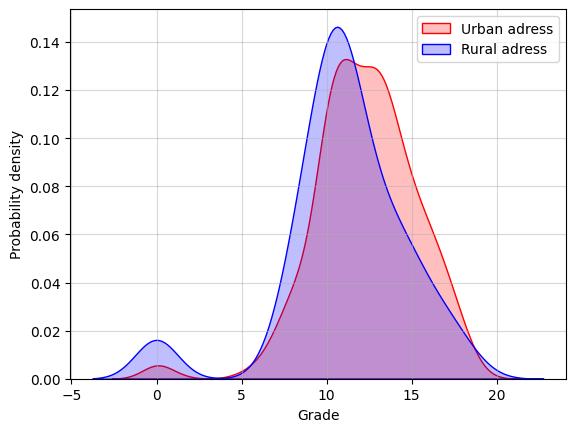

In [6]:
# Grade distribution by address
sns.kdeplot(data.loc[data['address'] == 'U', 'final_grade'], label='Urban adress', color= 'r', shade = True)
sns.kdeplot(data.loc[data['address'] == 'R', 'final_grade'], label='Rural adress', color='b', shade = True)
plt.xlabel('Grade');
plt.ylabel('Probability density')
plt.legend()
plt.grid(alpha=0.5); plt.show()

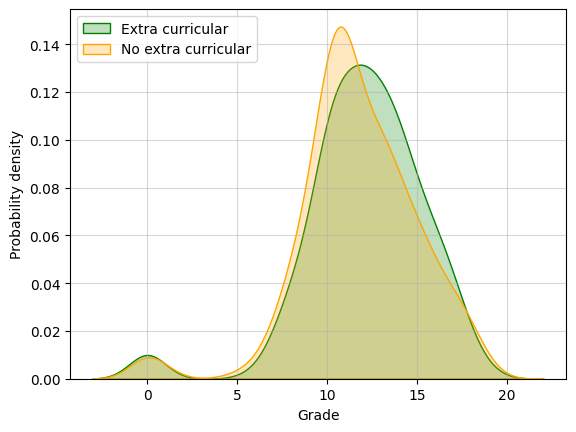

In [7]:
sns.kdeplot(data.loc[data['extra_curricular_activities'] == 'yes', 'final_grade'], label='Extra curricular', color= 'green', shade = True)
sns.kdeplot(data.loc[data['extra_curricular_activities'] == 'no', 'final_grade'], label='No extra curricular', color= 'orange', shade = True)
plt.xlabel('Grade');
plt.ylabel('Probability density')
plt.legend(loc='upper left')
plt.grid(alpha=0.5); plt.show()

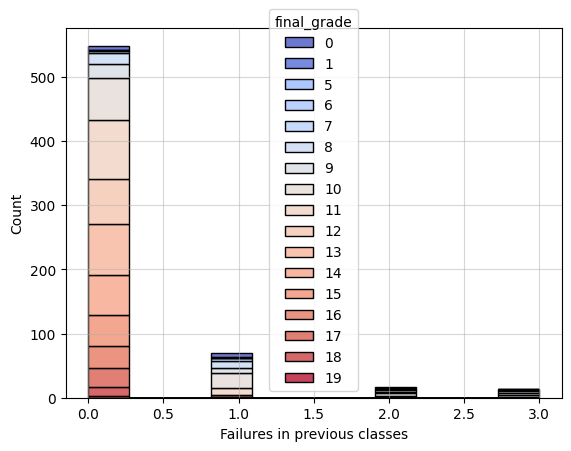

In [8]:
sns.histplot(data=data, x="failures", hue="final_grade", multiple="stack", palette='coolwarm')
plt.xlabel("Failures in previous classes")
plt.grid(alpha=0.5); plt.show()
# If a person has failures: 4, that means they didn't get a final grade

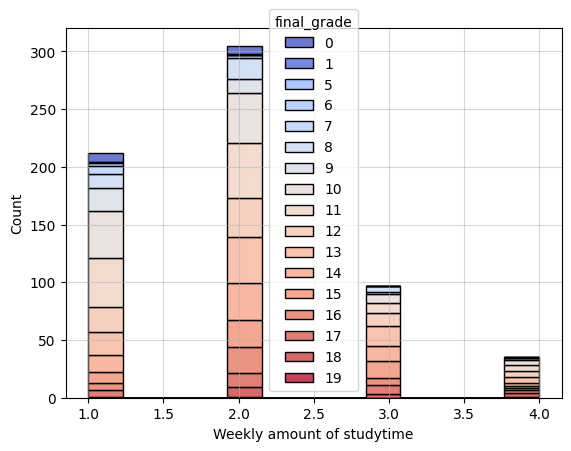

In [9]:
sns.histplot(data=data, x="studytime", hue="final_grade", multiple="stack", palette='coolwarm')
plt.xlabel("Weekly amount of studytime")
plt.grid(alpha=0.5); plt.show()
#  weekly study time (numeric: 1 - <2 hours, 2 - 2 to 5 hours, 3 - 5 to 10 hours, or 4 - >10 hours)

In [10]:
# CLEAN THE DATABASE # 

# 3. Get the dummies so that it is easier to work. 
# This is, transform the categorical columns into numerical ones. 
# This is an example of One hot encoding
data_clean = pd.get_dummies(data, columns=categorical_columns)

# 4. Transform the data. 
# we need to standarize the data to take into consideration variations in measurments, units and scales. 
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data[numerical_columns])
scaled_dataframe = pd.DataFrame(scaled_data, columns = numerical_columns)  
scaled_dataframe.head()

for column in numerical_columns:
  data_clean.append(scaled_dataframe[column])
  data_clean[column] = scaled_dataframe[column]

In [11]:
corr = data_clean.corr()
corr.style.background_gradient(cmap='coolwarm', axis=None).set_precision(2)

,age,mother_education,father_education,traveltime,studytime,failures,famrel,freetime,going_out,workday_alcohol,weekend_alcohol,health,absences,grade_period1,grade_period2,final_grade,school_GP,school_MS,sex_F,sex_M,address_R,address_U,family_size_GT3,family_size_LE3,parent_cohabition_status_A,parent_cohabition_status_T,mother_job_at_home,mother_job_health,mother_job_other,mother_job_services,mother_job_teacher,father_job_at_home,father_job_health,father_job_other,father_job_services,father_job_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other,school_support_no,school_support_yes,family_support_no,family_support_yes,paid_no,paid_yes,extra_curricular_activities_no,extra_curricular_activities_yes,nursery_no,nursery_yes,higher_no,higher_yes,internet_access_no,internet_access_yes,romantic_no,romantic_yes
age,1.00,-0.11,-0.12,0.03,-0.01,0.32,-0.02,-0.00,0.11,0.13,0.09,-0.01,0.15,-0.17,-0.11,-0.11,-0.09,0.09,0.04,-0.04,0.03,-0.03,0.00,-0.00,0.01,-0.01,0.09,-0.10,0.04,-0.03,-0.05,0.06,-0.10,0.06,-0.02,-0.05,0.03,-0.01,-0.01,-0.02,-0.14,-0.05,0.33,0.17,-0.17,0.10,-0.10,0.01,-0.01,0.05,-0.05,0.02,-0.02,0.27,-0.27,-0.01,0.01,-0.18,0.18
mother_education,-0.11,1.00,0.65,-0.27,0.10,-0.17,0.02,-0.02,0.01,-0.01,-0.02,0.00,-0.01,0.26,0.26,0.24,0.25,-0.25,-0.12,0.12,-0.19,0.19,0.01,-0.01,0.06,-0.06,-0.38,0.26,-0.22,0.13,0.45,-0.10,0.16,-0.12,-0.01,0.26,-0.12,0.04,-0.03,0.13,-0.04,0.09,-0.10,0.02,-0.02,-0.12,0.12,-0.11,0.11,-0.12,0.12,-0.13,0.13,-0.21,0.21,-0.27,0.27,0.03,-0.03
father_education,-0.12,0.65,1.00,-0.21,0.05,-0.17,0.02,0.01,0.03,0.00,0.04,0.04,0.03,0.22,0.23,0.21,0.21,-0.21,-0.08,0.08,-0.14,0.14,0.04,-0.04,0.03,-0.03,-0.20,0.14,-0.20,0.10,0.31,-0.11,0.23,-0.22,0.03,0.35,-0.07,0.02,-0.03,0.09,0.09,-0.04,-0.07,-0.02,0.02,-0.14,0.14,-0.09,0.09,-0.08,0.08,-0.07,0.07,-0.19,0.19,-0.18,0.18,0.07,-0.07
traveltime,0.03,-0.27,-0.21,1.00,-0.06,0.10,-0.01,0.00,0.06,0.09,0.06,-0.05,-0.01,-0.15,-0.15,-0.13,-0.25,0.25,-0.04,0.04,0.34,-0.34,-0.01,0.01,-0.04,0.04,0.17,-0.10,0.03,-0.07,-0.10,-0.04,-0.09,0.10,-0.03,-0.04,0.13,-0.13,0.06,-0.08,0.02,-0.07,0.09,0.04,-0.04,0.04,-0.04,0.04,-0.04,0.03,-0.03,0.01,-0.01,0.07,-0.07,0.19,-0.19,-0.00,0.00
studytime,-0.01,0.10,0.05,-0.06,1.00,-0.15,-0.00,-0.07,-0.08,-0.14,-0.21,-0.06,-0.12,0.26,0.24,0.25,0.14,-0.14,0.21,-0.21,-0.06,0.06,0.01,-0.01,0.01,-0.01,-0.04,-0.02,-0.00,0.03,0.04,-0.01,0.10,-0.04,0.01,-0.02,-0.08,-0.01,-0.09,0.18,0.02,-0.02,0.01,-0.09,0.09,-0.14,0.14,0.00,-0.00,-0.07,0.07,-0.04,0.04,-0.19,0.19,-0.04,0.04,-0.03,0.03
failures,0.32,-0.17,-0.17,0.10,-0.15,1.00,-0.06,0.11,0.05,0.11,0.08,0.04,0.12,-0.38,-0.39,-0.39,-0.11,0.11,-0.07,0.07,0.06,-0.06,0.07,-0.07,0.01,-0.01,0.10,-0.02,-0.00,0.01,-0.12,0.04,-0.06,0.04,-0.01,-0.08,0.16,-0.08,0.00,-0.11,-0.07,-0.06,0.23,0.00,-0.00,0.01,-0.01,-0.07,0.07,-0.00,0.00,0.07,-0.07,0.31,-0.31,0.10,-0.10,-0.07,0.07
famrel,-0.02,0.02,0.02,-0.01,-0.00,-0.06,1.00,0.13,0.09,-0.08,-0.09,0.11,-0.09,0.05,0.09,0.06,0.03,-0.03,-0.08,0.08,0.03,-0.03,-0.00,0.00,-0.05,0.05,-0.01,-0.03,-0.01,0.04,-0.00,-0.08,0.01,0.02,0.04,-0.05,-0.02,-0.02,0.02,0.03,0.03,0.01,-0.07,0.01,-0.01,-0.02,0.02,-0.03,0.03,-0.06,0.06,-0.04,0.04,-0.05,0.05,-0.08,0.08,0.04,-0.04
freetime,-0.00,-0.02,0.01,0.00,-0.07,0.11,0.13,1.00,0.35,0.11,0.12,0.08,-0.02,-0.09,-0.11,-0.12,-0.03,0.03,-0.15,0.15,0.04,-0.04,0.02,-0.02,-0.04,0.04,-0.02,-0.02,-0.02,0.01,0.06,0.03,-0.02,0.04,-0.05,0.00,0.08,-0.06,-0.03,-0.01,-0.04,0.02,0.03,0.02,-0.02,-0.00,0.00,0.05,-0.05,-0.15,0.15,0.01,-0.01,0.10,-0.10,-0.06,0.06,-0.03,0.03
going_out,0.11,0.01,0.03,0.06,-0.08,0.05,0.09,0.35,1.00,0.25,0.39,-0.02,0.09,-0.07,-0.08,-0.09,-0.04,0.04,-0.06,0.06,-0.02,0.02,0.00,-0.00,-0.03,0.03,-0.04,0.04,0.01,0.04,-0.06,-0.01,0.03,0.04,-0.03,-0.04,0.01,-0.01,0.00,-0.00,-0.06,0.04,0.02,0.06,-0.06,-0.02,0.02,0.01,-0.01,-0.09,0.09,-0.02,0.02,0.07,-0.07,-0.09,0.09,0.00,-0.00
workday_alcohol,0.13,-0.01,0.00,0.09,-0.14,0.11,-0.08,0.11,0.25,1.00,0.62,0.06,0.17,-0.20,-0.19,-0.20,-0.05,0.05,

In [12]:
# Here we can see more clearly the correlations for only the target variable.

x = corr[['final_grade']]
x.T.style.background_gradient(cmap='coolwarm', axis=None).set_precision(2)

,age,mother_education,father_education,traveltime,studytime,failures,famrel,freetime,going_out,workday_alcohol,weekend_alcohol,health,absences,grade_period1,grade_period2,final_grade,school_GP,school_MS,sex_F,sex_M,address_R,address_U,family_size_GT3,family_size_LE3,parent_cohabition_status_A,parent_cohabition_status_T,mother_job_at_home,mother_job_health,mother_job_other,mother_job_services,mother_job_teacher,father_job_at_home,father_job_health,father_job_other,father_job_services,father_job_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other,school_support_no,school_support_yes,family_support_no,family_support_yes,paid_no,paid_yes,extra_curricular_activities_no,extra_curricular_activities_yes,nursery_no,nursery_yes,higher_no,higher_yes,internet_access_no,internet_access_yes,romantic_no,romantic_yes
final_grade,-0.11,0.24,0.21,-0.13,0.25,-0.39,0.06,-0.12,-0.09,-0.20,-0.18,-0.10,-0.09,0.83,0.92,1.00,0.28,-0.28,0.13,-0.13,-0.17,0.17,-0.05,0.05,0.00,-0.00,-0.14,0.10,-0.06,0.04,0.13,-0.04,0.04,-0.01,-0.05,0.13,-0.10,0.05,-0.13,0.17,0.05,-0.00,-0.08,0.07,-0.07,-0.06,0.06,0.05,-0.05,-0.06,0.06,-0.03,0.03,-0.33,0.33,-0.15,0.15,0.09,-0.09


In [13]:
# CORRELATION MATRIX WITH LESS VARIABLES # 
# FUNCTION #

# 1. create the function 
def corr_matrix(chosen_columns):
  bm = data_clean.columns.isin(chosen_columns)
  sc = data_clean.columns[bm]
  df=data_clean[sc]
  corr = df.corr()
  return(corr.style.background_gradient(cmap='coolwarm', axis=None).set_precision(2))

# 2.choose the variables in which we want to see the correlation
chosen = ["sex_M","sex_F","internet_access_no","romantic_yes","paid_yes", "final_grade"]

# 3. call the function 
corr_matrix(chosen)

,final_grade,sex_F,sex_M,paid_yes,internet_access_no,romantic_yes
final_grade,1.00,0.13,-0.13,-0.05,-0.15,-0.09
sex_F,0.13,1.00,-1.00,-0.08,0.07,0.11
sex_M,-0.13,-1.00,1.00,0.08,-0.07,-0.11
paid_yes,-0.05,-0.08,0.08,1.00,-0.03,-0.02
internet_access_no,-0.15,0.07,-0.07,-0.03,1.00,-0.03
romantic_yes,-0.09,0.11,-0.11,-0.02,-0.03,1.00


In [14]:
# These features seem to have the highest correlation with final_grade
print(corr.abs().nlargest(10, 'final_grade').index)

Index(['final_grade', 'grade_period2', 'grade_period1', 'failures',
       'higher_no', 'higher_yes', 'school_GP', 'school_MS', 'studytime',
       'mother_education'],
      dtype='object')


In [15]:
boolean_mask = data_clean.columns.isin(['age', 'mother_education', 'father_education', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'going_out',
       'workday_alcohol', 'weekend_alcohol', 'health', 'absences', 'school_GP', 'school_MS', 'sex_F', 'sex_M', 'address_R', 'address_U',
       'family_size_GT3', 'family_size_LE3', 'parent_cohabition_status_A', 'parent_cohabition_status_T', 'mother_job_at_home', 'mother_job_health',
       'mother_job_other', 'mother_job_services', 'mother_job_teacher', 'father_job_at_home', 'father_job_health', 'father_job_other','father_job_services', 
       'father_job_teacher', 'reason_course', 'reason_home', 'reason_other', 'reason_reputation', 'guardian_father', 'guardian_mother', 'guardian_other', 
       'school_support_yes','family_support_yes', 'paid_yes', 'extra_curricular_activities_yes', 'nursery_yes', 'higher_yes', 'internet_access_yes','romantic_yes'])
sc = data_clean.columns[boolean_mask]
X=data_clean[sc]

boolean_mask_target = data_clean.columns.isin(["final_grade"])
s = data_clean.columns[boolean_mask_target]
y=data_clean[s]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, shuffle=True) # 0.25 x 0.8 = 0.2, validation set is 20% of training set


In [16]:
# FURTHER CLEANING #
# These features cause to much bias for models with the task of predicting final grades.
data_without_G1_G2 = data_clean.drop(["grade_period1","grade_period2"], axis=1)

## Principal Component Analysis

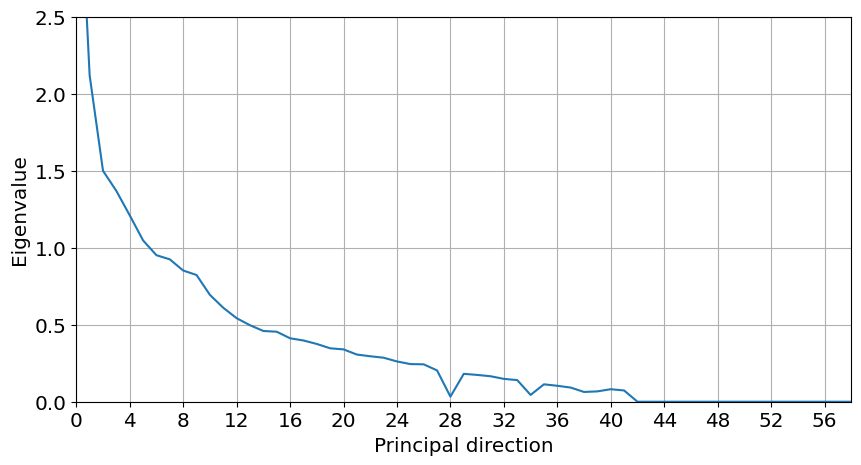

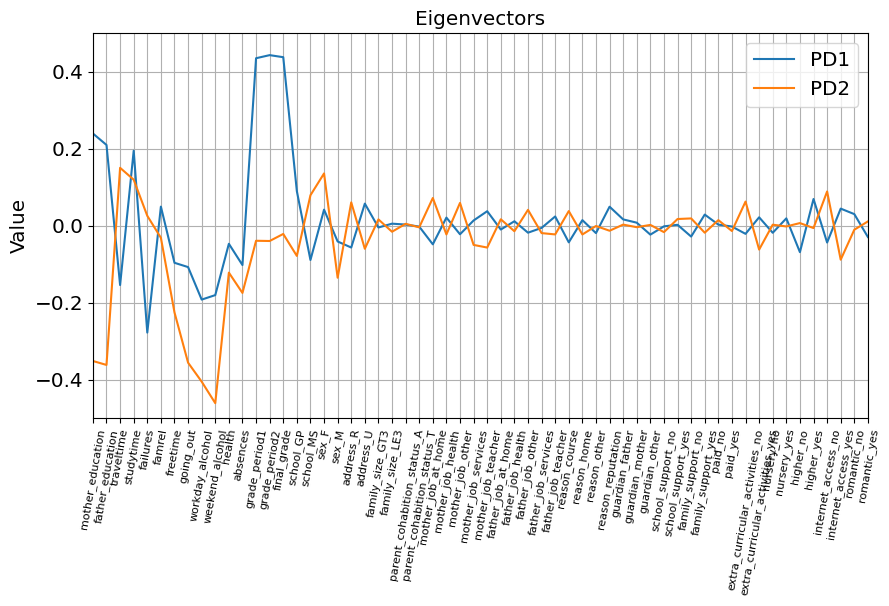

In [17]:
# EIGENVECTORS AND EIGENVALUES #

# 1. Get the covariance matrix
cov = data_clean.cov()

# 2. Computes the eigenvalue and eigenvector of the square.
# The eigenvectors are the directions in which the data varies the most --> L
# The eigenvalues represent the magnitude of the variance in those directions -->  Q
L,Q = np.linalg.eig(cov)

# 3. Plotting the eigenvalues. 
# The plot will show the importance of each principal component in terms of
# the amount of variance it captures. The first principal component will have the 
# largest eigenvalue, followed by the second, and so on. The plot can help you decide 
# how many principal components to retain based on a certain amount of variance explained, 
# or it can be used to visualize the structure of the data in a lower-dimensional space.

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(range(len(L)),L)
plt.xticks(ticks = range(len(L)))
plt.ylabel('Eigenvalue')
plt.xlabel('Principal direction')
plt.xlim((1, len(L)-1))
plt.xticks(range(0,60,4))

plt.ylim((0,2.5))
ax.grid()
plt.show()

# 4. Plotting eigenvectors. 
# Now, we'll proceed to plot the 2 eigenvectors in Q having the largest eigenvalues. 
# The plot can be useful for visualizing the structure of the data in a lower-dimensional 
# space and for identifying any patterns or clusters in the data.

print("\n")
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(range(len(L)),Q[:,0:2])
plt.xticks(ticks = range(len(L)), labels=data_clean.columns,rotation=80, fontsize=8)
ax.legend(labels=['PD1','PD2'])
plt.ylabel('Value')
plt.xlim((1, len(L)-1))
plt.ylim((-0.5,0.5))
plt.title("Eigenvectors")
ax.grid()
plt.show()
     

Principal components are new variables that are constructed as linear combinations or mixtures of the initial variables. These combinations are done in such a way that the new variables (i.e., principal components) are uncorrelated and most of the information within the initial variables is squeezed or compressed into the first components. 

So, the idea is 10-dimensional data gives you 10 principal components, but PCA tries to put maximum possible information  in the first component, then maximum remaining information in the second and so on. Organizing information in principal components this way, will allow us to reduce dimensionality without losing much information. An important thing to realize here is that the principal components are less interpretable and don’t have any real meaning since they are constructed as linear combinations of the initial variables.

How to Select the Best Number of Principal Components for the Dataset?

 1. Scree plot method. 2. Cumulative explained variance 3. Cross validation

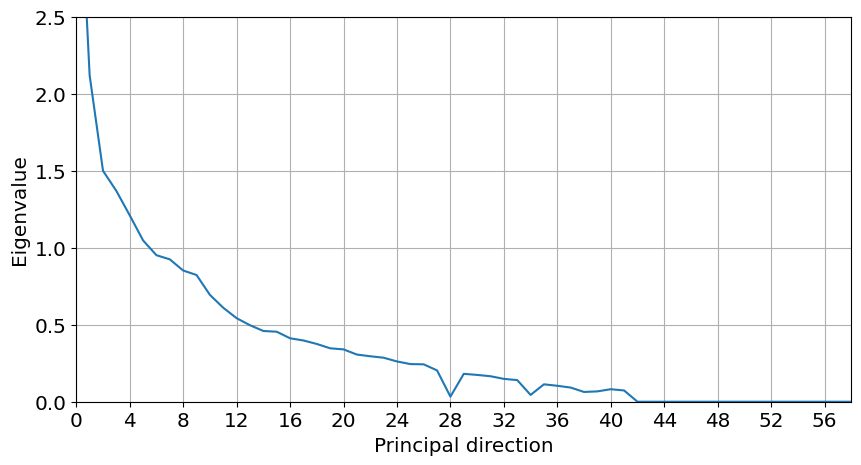

In [18]:
# PCA #
# Method 1: Scree plot method
# This one takes the same criteria as the elbow plot. 

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(range(len(L)),L)
plt.xticks(ticks = range(len(L)))
plt.ylabel('Eigenvalue')
plt.xlabel('Principal direction')
plt.xlim((1, len(L)-1))
plt.xticks(range(0,60,4))

plt.ylim((0,2.5))
ax.grid()
plt.show()

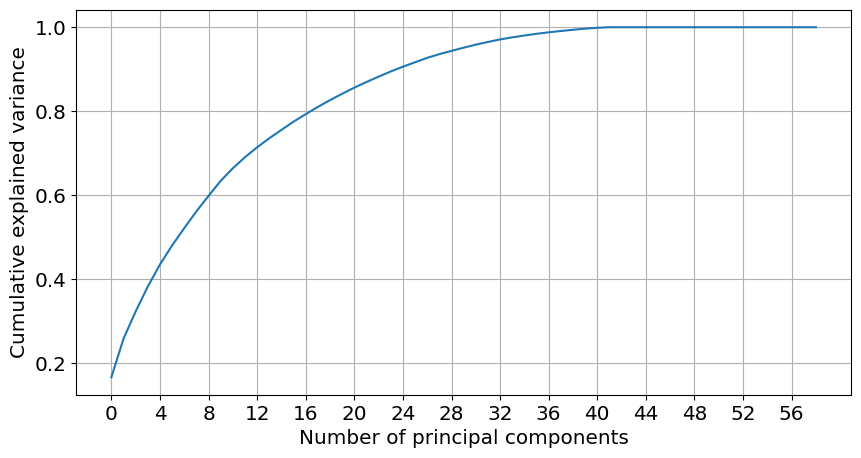

In [19]:
# PCA #
# Method 2: Cumulative explained variance. 
# Usually, one seeks to have an explained variance between 0.6 and 0.8. 

pca = PCA().fit(data_clean)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of principal components')
plt.ylabel('Cumulative explained variance')
plt.xticks(range(0,60,4))
plt.grid() 

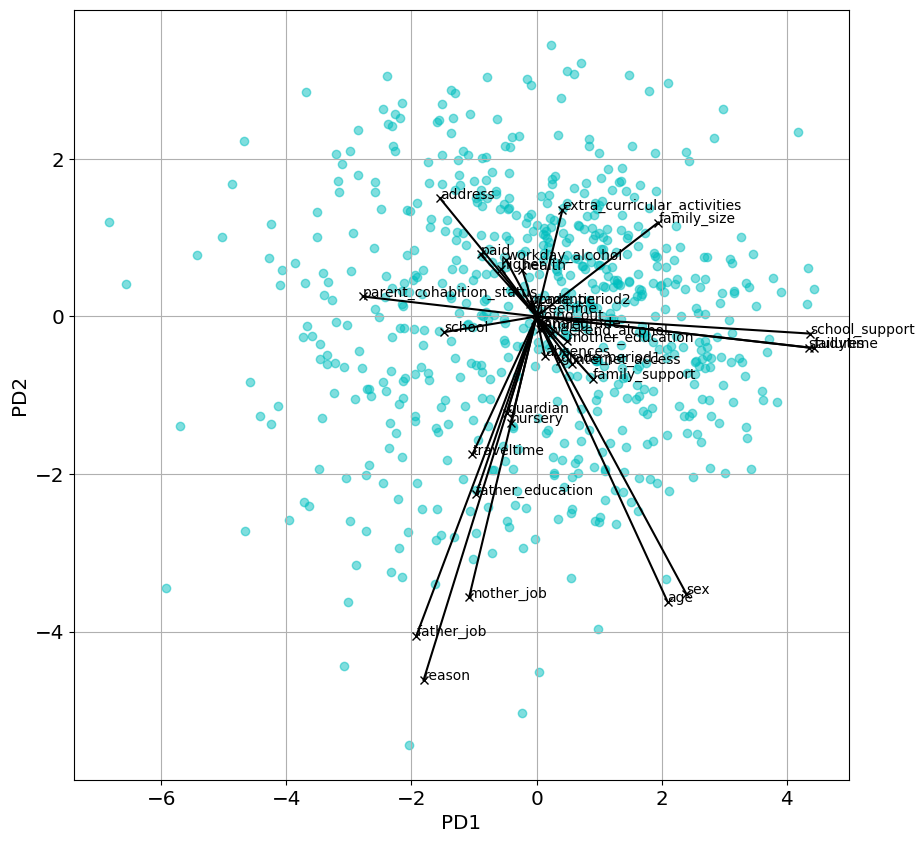

In [20]:
x = data_clean.to_numpy()

Xproj = np.dot(Q[:,(0,1)].T,(x-x.mean(axis=0)).T).T

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 10),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

fig = plt.figure()
ax = fig.add_subplot(111)

hand = ax.scatter(Xproj[:,0],Xproj[:,1],alpha=0.5, color="c")

# add the standard basis
for dim in range(len(data.columns)):
  ax.plot((0,10*Q[dim,0]),(0,10*Q[dim,1]),c='black')
  ax.text(10*Q[dim,0],10*Q[dim,1],data.columns[dim],fontsize=10)
  ax.plot(10*Q[dim,0],10*Q[dim,1],marker='x',c='black')

plt.xlabel('PD1')
plt.ylabel('PD2')
ax.grid()
plt.show()

In this graph, we see for example that grade_period2 point in the same direction as free time and school support, as well as study time and failures. 

Another trend we can see in this particular dataset is that the parents' of the students seems to be in a similar line of work. It is peculiar though, that mother_job and father_job point in the same direction as father_education, but not mother_education.

## Feature selection

In [21]:
# Creating a SelectKBest object to perform feature selection, which will be used for making the models more accurate
# We have also used feature selection with the Lasso model, which we will try out in the Lasso section.
k_best = SelectKBest(f_classif,k=8)
X_new = k_best.fit_transform(X, y) 
sel_mask = k_best.get_support()
featurenames = X.columns
print("Selected features are:")
for nn in np.where(sel_mask)[0]:
  print(featurenames[nn])

Selected features are:
age
mother_education
father_education
failures
workday_alcohol
school_GP
school_MS
higher_yes


In [22]:
list_wit_features = []
features_selected = np.argwhere(k_best.get_support())
for ff in features_selected:
    list_wit_features.append(X_train.columns[ff][0])
print(list_wit_features)

['age', 'mother_education', 'father_education', 'failures', 'workday_alcohol', 'school_GP', 'school_MS', 'higher_yes']


## Linear regression

In [23]:
# 1. Split into training, testing and validation data.
boolean_mask = data_clean.columns.isin(['age', 'mother_education', 'father_education', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'going_out',
       'workday_alcohol', 'weekend_alcohol', 'health', 'absences', 'grade_period1', 'grade_period2', 'school_GP', 'school_MS', 'sex_F', 'sex_M', 'address_R', 'address_U',
       'family_size_GT3', 'family_size_LE3', 'parent_cohabition_status_A', 'parent_cohabition_status_T', 'mother_job_at_home', 'mother_job_health',
       'mother_job_other', 'mother_job_services', 'mother_job_teacher', 'father_job_at_home', 'father_job_health', 'father_job_other','father_job_services', 
       'father_job_teacher', 'reason_course', 'reason_home', 'reason_other', 'reason_reputation', 'guardian_father', 'guardian_mother', 'guardian_other', 
       'school_support_yes','family_support_yes', 'paid_yes', 'extra_curricular_activities_yes', 'nursery_yes', 'higher_yes', 'internet_access_yes','romantic_yes'])
sc = data_clean.columns[boolean_mask]
X_lr =data_clean[sc]

boolean_mask_target = data_clean.columns.isin(["final_grade"])
s = data_clean.columns[boolean_mask_target]
y_lr = data_clean[s]

X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X_lr, y_lr, test_size=0.2, shuffle=True)
X_train_lr, X_val_lr, y_train_lr, y_val_lr = train_test_split(X_train_lr, y_train_lr, test_size=0.25, shuffle=True) # 0.25 x 0.8 = 0.2, validation set is 20% of training set

# 2. Fit the model, get the prediction and get the accuracy.
linear_model = LinearRegression()
linear_model.fit(X_train_lr, y_train_lr)
print("Linear regression:")

y_pred = linear_model.predict(X_val_lr)

print("Accuracy:", linear_model.score(X_val_lr,y_val_lr))   # linear_model.score uses R-squared metric by default

mse_tot = mean_squared_error(y_val_lr, y_val_lr)  

print("Mean squared error: %.10f" % mse_tot)  

# 3. Get the coefficients of the regression model:
coefficient={}
for feat in X_train_lr.columns:
  coefficient[feat]=linear_model.coef_

# print(coefficient["traveltime"])

Linear regression:
Accuracy: 0.8273323262491677
Mean squared error: 0.0000000000


In [24]:
# TESTING ON UNSEEN DATA #

y_pred_new = linear_model.predict(X_test_lr)  

print("Accuracy:", linear_model.score(X_test_lr,y_test_lr))   # linear_model.score uses R-squared metric by default
mse_tot = mean_squared_error(y_test_lr, y_pred_new)

print("Mean squared error: %.10f" % mse_tot)

Accuracy: 0.869241472363105
Mean squared error: 0.1100292090


The accuracy dropped a bit, which is expected.

Measuring the success with cross-validation will yield a more trustable accuracy and prevents the consequences of drawing conclusions from a "lucky" or "unlucky" sample.

In [25]:
# CROSS-VALIDATION #

boolean_mask = data_clean.columns.isin(['age', 'mother_education', 'father_education', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'going_out',
       'workday_alcohol', 'weekend_alcohol', 'health', 'absences', 'grade_period1', 'grade_period2', 'school_GP', 'school_MS', 'sex_F', 'sex_M', 'address_R', 'address_U',
       'family_size_GT3', 'family_size_LE3', 'parent_cohabition_status_A', 'parent_cohabition_status_T', 'mother_job_at_home', 'mother_job_health',
       'mother_job_other', 'mother_job_services', 'mother_job_teacher', 'father_job_at_home', 'father_job_health', 'father_job_other','father_job_services', 
       'father_job_teacher', 'reason_course', 'reason_home', 'reason_other', 'reason_reputation', 'guardian_father', 'guardian_mother', 'guardian_other', 
       'school_support_yes','family_support_yes', 'paid_yes', 'extra_curricular_activities_yes', 'nursery_yes', 'higher_yes', 'internet_access_yes','romantic_yes'])
sc = data_clean.columns[boolean_mask]
X_lr =data_clean[sc]

boolean_mask_target = data_clean.columns.isin(["final_grade"])
s = data_clean.columns[boolean_mask_target]
y_lr = data_clean[s]

X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X_lr, y_lr, test_size=0.2, shuffle=True)

# The data will be split into 10 equal parts, and the model will be trained and 
# evaluated 10 times. 
folds = 10

# 3. Evaluate the linear regression model using cross validation. 

# Linear regression is a supervised machine learning algorithm used for predicting a 
# continuous target variable based on one or more input features that have a linear
# relationship with the target variable.

# The linear regression model assumes that the relationship between the input 
# features and the target variable can be modeled using a linear function, which 
# is a straight line in the case of a single input feature or a plane in the case of multiple input features.

kf = KFold(n_splits=folds, shuffle=True, random_state=42)
linear_model = LinearRegression()
scores = cross_val_score(linear_model, X_lr, y_lr, cv=kf)

# 4. Print the cross-validation scores
print("Validation scores:")
l=len(scores)
for i in range(l):
  print(i+1,":",scores[i])

# 5. Average score
# The results of the cross validation are averaged across the k 
# folds to produce an overall estimate of the model's performance.
# The average score represents the average performance of the ML model across all folds of the cross-validation.
print("\n")
print("Average score:", np.mean(scores))
print("Standard deviation:", np.std(scores))

Validation scores:
1 : 0.9170999697955702
2 : 0.7877310628454697
3 : 0.9037058355011426
4 : 0.7480818453558322
5 : 0.7814976884499466
6 : 0.768025810237439
7 : 0.8497083528005329
8 : 0.8790618622479159
9 : 0.8016115702932598
10 : 0.9172932477254174


Average score: 0.8353817245252527
Standard deviation: 0.06216216405866742


In [26]:
# Which were the predicted grades? #

# Now we want to examine what the predicted grade values actually is, in the shape and form they originally have in the dataset. 

y_pred_rescaled = y_pred * data["final_grade"].std() + data["final_grade"].mean()
# print(y_pred_rescaled)   # these are the predicted grades in their original form
print("Mean of predicted grades:", y_pred_rescaled.mean())

Mean of predicted grades: 11.576500267102556


Side note: the data is splitted randomly with shuffle = True for each run, which will result in slightly different values.

One thing that is important to note is that two of the features that affects these results the most are 'grade_period1' and 'grade_period2', which are also measures of grades. These have, as we can see, a very high correlation with the final grade, which is problematic. We have a biased model.We should try just how much the current accuracy depends on these by removing them from the data.

For science sake, we have to test how the model performs without these features.

### Linear regression without grade_period1 and grade_period2

From now on, we will use the train/test split defined earlier, where labels "grade_period1" and "grade_period2" have been dropped. This is so that all the models using these values of X and y gets the same random split, so that they can be compared with each other and are easy to implement.

In [27]:
# Fit the model, get the prediction and get the accuracy.
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
print("Linear regression:")

y_pred = linear_model.predict(X_val)

kf = KFold(n_splits=folds, shuffle=True, random_state=42)
scores = cross_val_score(linear_model, X, y, cv=kf)

# Print the cross-validation scores
print("Validation scores:")
l=len(scores)
for i in range(l):
  print(i+1,":",scores[i])

# Average score
print("\n")
print("Average score:", np.mean(scores))
print("Standard deviation:", np.std(scores))

mse_tot = mean_squared_error(y_test, y_pred)  

print("Mean squared error: %.10f" % mse_tot)  

# Get the coefficients of the regression model:
coefficient={}
for feat in X_train_lr.columns:
  coefficient[feat]=linear_model.coef_

# print(coefficient["traveltime"])

Linear regression:
Validation scores:
1 : 0.060985498597115995
2 : 0.1734890928168964
3 : 0.34782216735197413
4 : 0.341910952969562
5 : 0.35865908118486367
6 : 0.2200140145517946
7 : 0.2962464153738503
8 : 0.2872317689182139
9 : 0.10562810985504212
10 : 0.2161806092271118


Average score: 0.24081677108464256
Standard deviation: 0.0984742443900334
Mean squared error: 1.8912816008


We are getting a much lower accuracy after the grades from previous periods are dropped from the data. This was expected, since these features had such a high correlation with the final grade. This accuracy is a better representation of how the linear regression model actually performs, since it the data doesn't contain bias of how the grades should look. 

In the next chapter, where we will implement a Lasso regression model, we will first take a look at how the model performs with all of the data, and then with the data without "grade_period1" and "grade_period2".

## Lasso regression

In [28]:
# A function to determine which will be the best alpha value for Lasso regression in following cell.

alphas = np.arange(0,1,0.001).tolist()
def best_alpha(X, y, alpha_values=alphas):
    """
    Here we can test which the best alpha value is, using cross-validation for a Lasso model.

    Input: X is a feature matrix and y is a target vector. 
    
    We will test all alpha values in the list of alpha values.
    """
    
    lasso = LassoCV(alphas=alpha_values, cv=5, random_state=42)
    lasso.fit(X, y)
    
    best_alpha = lasso.alpha_
    
    return best_alpha

In [29]:
# 1. Split into training and testing data.
boolean_mask = data_clean.columns.isin(['age', 'mother_education', 'father_education', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'going_out',
       'workday_alcohol', 'weekend_alcohol', 'health', 'absences', 'grade_period1', 'grade_period2', 'school_GP', 'school_MS', 'sex_F', 'sex_M', 'address_R', 'address_U',
       'family_size_GT3', 'family_size_LE3', 'parent_cohabition_status_A', 'parent_cohabition_status_T', 'mother_job_at_home', 'mother_job_health',
       'mother_job_other', 'mother_job_services', 'mother_job_teacher', 'father_job_at_home', 'father_job_health', 'father_job_other','father_job_services', 
       'father_job_teacher', 'reason_course', 'reason_home', 'reason_other', 'reason_reputation', 'guardian_father', 'guardian_mother', 'guardian_other', 
       'school_support_yes','family_support_yes', 'paid_yes', 'extra_curricular_activities_yes', 'nursery_yes', 'higher_yes', 'internet_access_yes','romantic_yes'])

sc = data_clean.columns[boolean_mask]
X_lasso = data_clean[sc]

boolean_mask_target = data_clean.columns.isin(["final_grade"])
s = data_clean.columns[boolean_mask_target]
y_lasso = data_clean[s]

X_train_lasso, X_test_lasso, y_train_lasso, y_test_lasso = train_test_split(X_lasso, y_lasso, test_size=0.2, shuffle=True)
X_train_lasso, X_val_lasso, y_train_lasso, y_val_lasso = train_test_split(X_train_lasso, y_train_lasso, test_size=0.25, shuffle=True)

# 2. Fit the model and get the accuracy.
best_alpha_for_lasso = best_alpha(X_train_lasso, y_train_lasso)
print("The alpha value we will use is:", best_alpha_for_lasso)
lasso_model=Lasso(alpha=best_alpha_for_lasso)
lasso_model.fit(X_train_lasso, y_train_lasso)

# 3. Make the predictions, first on the validation set to measure suitability of the model.
y_pred = lasso_model.predict(X_val_lasso)


# 4. Get the slope and the intercept. 
# y = mx + b, where m represents the slope and b represents the y-intercept.
print("Slope",lasso_model.coef_[0])
print("Intercept:",lasso_model.intercept_)
print("\n")

# 5. Evaluate the performance of our model
# Method 1: mean squared error
# Disadvantage it's difficult to evaluate the performance of the model using MSE as the value of MSE can vary from 0 to any larger number
mse = mean_squared_error(y_val_lasso,y_pred)
print("Mean squared error:", mse)

# Method 2: R2.
# The value of R2 varies between 0 and 1. 
r2=lasso_model.score(X_val_lasso,y_val_lasso)

print("R2:",r2)


# 6. Get Lasso coefficients and select a few features to improve the model accuracy
sel = SelectFromModel(lasso_model)
removed_features = X_train_lasso.columns[(sel.estimator.coef_ == 0).ravel().tolist()]
chosen_features = X_train_lasso.columns[(sel.estimator.coef_ != 0).ravel().tolist()]

print("Selected features with Lasso:", "\n", chosen_features)

The alpha value we will use is: 0.019
Slope 0.0
Intercept: [0.00715481]


Mean squared error: 0.17599926185928533
R2: 0.8593897480089111
Selected features with Lasso: 
 Index(['failures', 'going_out', 'health', 'absences', 'grade_period1',
       'grade_period2', 'school_GP', 'school_MS'],
      dtype='object')


In [30]:
# LASSO REGRESSION AFTER FEATURE SELECTION #

boolean_mask = data_clean.columns.isin(chosen_features.tolist())
sc = data_clean.columns[boolean_mask]
X_lasso = data_clean[sc]

boolean_mask_target = data_clean.columns.isin(["final_grade"])
s = data_clean.columns[boolean_mask_target]
y_lasso = data_clean[s]

X_train_lasso, X_test_lasso, y_train_lasso, y_test_lasso = train_test_split(X_lasso, y_lasso, test_size=0.2, shuffle=True)
X_train_lasso, X_val_lasso, y_train_lasso, y_val_lasso = train_test_split(X_train_lasso, y_train_lasso, test_size=0.25, shuffle=True)

# 2. Fit the model and get the accuracy.
# best_alpha_for_lasso = best_alpha(X_train, y_train)
# print("The alpha value we will use is:", best_alpha_for_lasso)
lasso_model=Lasso(alpha=best_alpha_for_lasso)
lasso_model.fit(X_train_lasso, y_train_lasso)

# 3. Make the predictions on the validation set.
y_pred = lasso_model.predict(X_val_lasso)

# 4. Get the slope and the intercept. 
# y = mx + b, where m represents the slope and b represents the y-intercept.
print("Slope",lasso_model.coef_[0])
print("Intercept:",lasso_model.intercept_)
print("\n")

# 5. Evaluate the performance of our model
# Method 1: mean squared error
# Disadvantage it's difficult to evaluate the performance of the model using MSE as the value of MSE can vary from 0 to any larger number
mse = mean_squared_error(y_val_lasso,y_val_lasso)
print("Mean squared error:", mse)

# Method 2: R2.
# The value of R2 varies between 0 and 1. 
r2=lasso_model.score(X_val_lasso,y_val_lasso)
print("R2:",r2)

Slope -0.002683657731581204
Intercept: [0.00284655]


Mean squared error: 0.0
R2: 0.8116238974374136


In [31]:
# Now that we are happy with the model, we test the actual accuracies on the test set

y_pred_new = lasso_model.predict(X_test_lasso)

mse = mean_squared_error(y_test_lasso,y_test_lasso)
print("Mean squared error:", mse)

r2=lasso_model.score(X_test_lasso,y_test_lasso)
print("R2:",r2)

Mean squared error: 0.0
R2: 0.8061344254270498


### Lasso without "grade_period1" and "grade_period2" 

The final Lasso model will not be biased by grades in previous periods.

In [32]:
# Fit the model and get the accuracy.
best_alpha_for_lasso = best_alpha(X_train, y_train)
print("The alpha value we will use is:", best_alpha_for_lasso)
lasso_model = Lasso(alpha = best_alpha_for_lasso)
lasso_model.fit(X_train, y_train)

# Make the predictions, first on the validation set to measure suitability of the model.
y_pred = lasso_model.predict(X_val)


# Get the slope and the intercept. 
# y = mx + b, where m represents the slope and b represents the y-intercept.
print("Slope",lasso_model.coef_[0])
print("Intercept:",lasso_model.intercept_)
print("\n")

# Evaluate the performance of our model
# Method 1: mean squared error
# Disadvantage it's difficult to evaluate the performance of the model using MSE as the value of MSE can vary from 0 to any larger number
mse = mean_squared_error(y_val,y_pred)
print("Mean squared error:", mse)

# Method 2: R2.
# The value of R2 varies between 0 and 1. 
r2=lasso_model.score(X_val,y_val)

print("R2:",r2)

# Get Lasso coefficients and select a few features to improve the model accuracy
sel = SelectFromModel(lasso_model)
removed_features = X_train.columns[(sel.estimator.coef_ == 0).ravel().tolist()]
chosen_features = X_train.columns[(sel.estimator.coef_ != 0).ravel().tolist()]

print("Selected features with Lasso:", "\n", chosen_features)

The alpha value we will use is: 0.013000000000000001
Slope 0.1034815480001474
Intercept: [-0.57320336]


Mean squared error: 0.7129929199924192
R2: 0.21628860700253671
Selected features with Lasso: 
 Index(['age', 'mother_education', 'father_education', 'traveltime',
       'studytime', 'failures', 'famrel', 'freetime', 'going_out',
       'workday_alcohol', 'health', 'absences', 'school_GP', 'school_MS',
       'sex_F', 'family_size_GT3', 'family_size_LE3', 'mother_job_at_home',
       'mother_job_health', 'school_support_yes', 'family_support_yes',
       'paid_yes', 'extra_curricular_activities_yes', 'nursery_yes',
       'higher_yes', 'internet_access_yes', 'romantic_yes'],
      dtype='object')


In [33]:
# LASSO REGRESSION AFTER FEATURE SELECTION #

X_sel = data_without_G1_G2[chosen_features.tolist()]

boolean_mask_target = data_without_G1_G2.columns.isin(["final_grade"])
s = data_without_G1_G2.columns[boolean_mask_target]
y=data_without_G1_G2[s]

X_train, X_test, y_train, y_test = train_test_split(X_sel, y, test_size=0.2, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, shuffle=True)

lasso_model=Lasso(alpha=best_alpha_for_lasso)
lasso_model.fit(X_train, y_train)

# 3. Make the predictions on the validation set.
y_pred = lasso_model.predict(X_val)

# 4. Get the slope and the intercept. 
# y = mx + b, where m represents the slope and b represents the y-intercept.
print("Slope",lasso_model.coef_[0])
print("Intercept:",lasso_model.intercept_)
print("\n")

# 5. Evaluate the performance of our model
# Method 1: mean squared error
# Disadvantage it's difficult to evaluate the performance of the model using MSE as the value of MSE can vary from 0 to any larger number
mse = mean_squared_error(y_val,y_val)
print("Mean squared error:", mse)

# Method 2: R2.
# The value of R2 varies between 0 and 1. 
r2=lasso_model.score(X_val,y_val)
print("R2:",r2)

Slope 0.0859369215720981
Intercept: [-0.55372105]


Mean squared error: 0.0
R2: 0.28307589034229264


In [34]:
# Now we test the actual accuracies on the test set

y_pred_new = lasso_model.predict(X_test)

mse = mean_squared_error(y_test,y_test)
print("Mean squared error:", mse)

r2=lasso_model.score(X_test,y_test)
print("R2:",r2)

Mean squared error: 0.0
R2: 0.17394574235506866


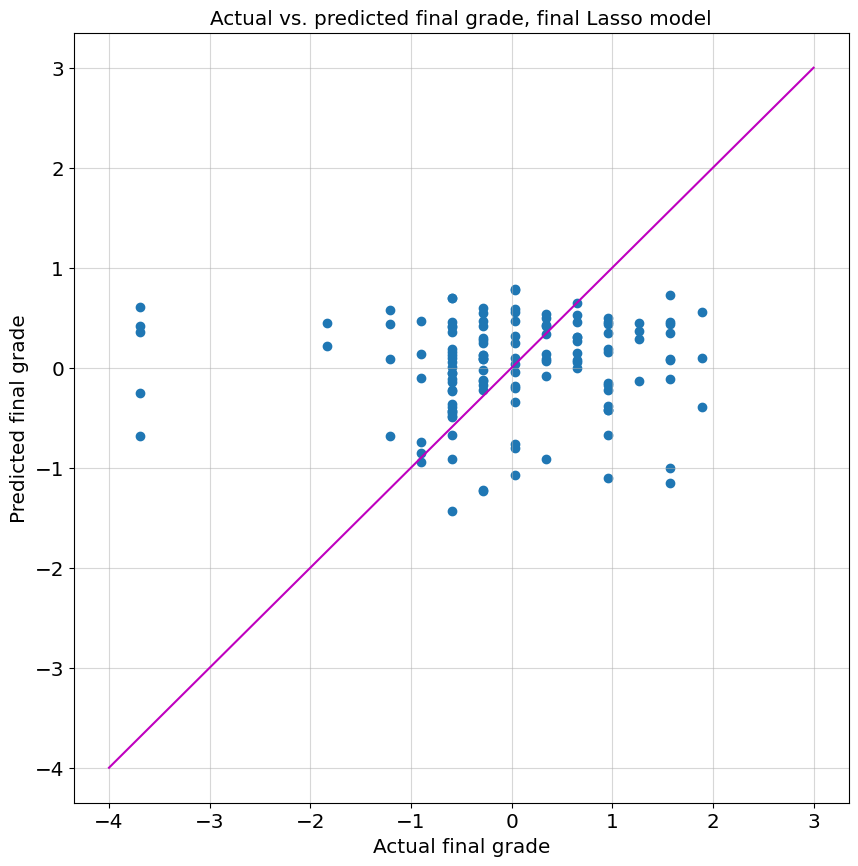

In [35]:
x = np.arange(-4, 4, 1)
plt.scatter(y_test_lasso, y_pred_new)
plt.xlabel("Actual final grade")
plt.ylabel("Predicted final grade")
plt.plot(x, x, color='m')
plt.title("Actual vs. predicted final grade, final Lasso model")
plt.grid(alpha=0.5); plt.show()

In [36]:
y_pred_rescaled = y_pred * data["final_grade"].std() + data["final_grade"].mean()
# print(y_pred_rescaled)   # these are the predicted grades in their original form
print("Mean of predicted grades:", y_pred_rescaled.mean())

Mean of predicted grades: 11.71780608203938


## K-means clustering

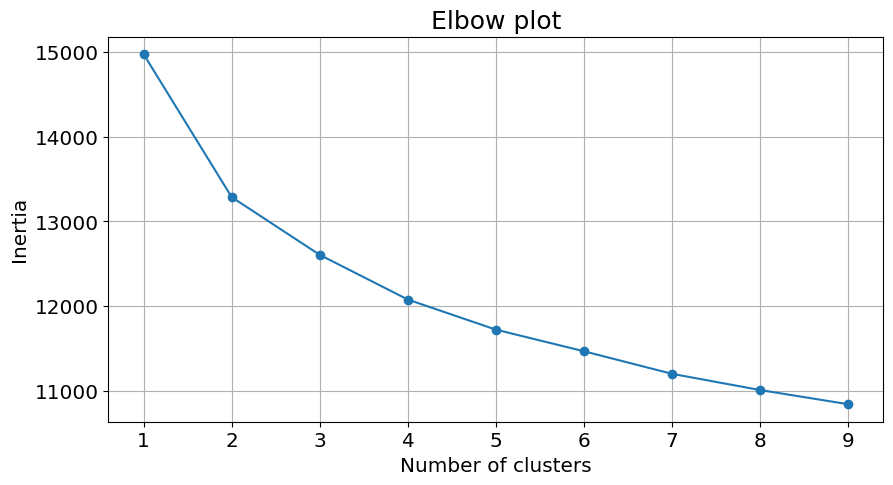



Silhouette method:
Silhouette score for k (clusters) = 2 is 0.11333391509438047
Silhouette score for k (clusters) = 3 is 0.06752484686386223
Silhouette score for k (clusters) = 4 is 0.07199776784435709
Silhouette score for k (clusters) = 5 is 0.05725816099761751
Silhouette score for k (clusters) = 6 is 0.049017575590438046
Silhouette score for k (clusters) = 7 is 0.0473258108480826
Silhouette score for k (clusters) = 8 is 0.04775985824607974
Silhouette score for k (clusters) = 9 is 0.04290048844251386


In [37]:
# CHOOSING THE OPTIMAL K VALUE #
# there is various methods to choose the optimun value of k. We'll start using the elbow plot method,
# and then proceed to the silhouette method. 
# The Elbow Method is more of a decision rule, while the Silhouette is a metric used for validation while clustering. 

# 1. ELBOW PLOT
# the elbow plot alows us to plot inercia (measure of how well the data was clustered by the KM alg) against the number of clusters. 
def optimise_k(data,max_k):
  means=[]
  inertias=[]
  for k in range(1,max_k):
    kmeans=KMeans(n_clusters=k)
    kmeans.fit(data)
    means.append(k)
    inertias.append(kmeans.inertia_)

  fig=plt.subplots(figsize=(10,5))
  plt.plot(means,inertias,"o-")
  plt.xlabel("Number of clusters")
  plt.ylabel("Inertia")
  plt.grid(True)
  plt.title("Elbow plot", size=18)
  plt.show()

optimise_k(data_clean,10)
# Optimun value of k: 4. 

# 2. THE SILHOUETTE METHOD
# The silhouette value measures how similar a point is to its own cluster (cohesion) compared to other clusters (separation).
print("\n")
print("Silhouette method:")
for i in range(2,10):
  labels=cluster.KMeans(n_clusters=i, init="k-means++",random_state=200).fit(data_clean).labels_
  print("Silhouette score for k (clusters) = "+str(i)+" is " + str(metrics.silhouette_score(data_clean,labels,metric="euclidean", sample_size=1000,random_state=200)))


[1 1 1 3 3 3 1 3 3 3 3 1 3 3 3 3 3 3 0 3 3 3 3 2 1 1 1 2 3 2 2 3 3 3 1 1 3
 3 3 1 1 2 3 1 1 1 3 3 3 3 1 3 2 3 2 1 3 3 1 3 3 2 1 3 3 3 2 1 1 3 1 1 1 1
 2 3 1 1 0 3 1 1 1 1 1 3 1 3 1 2 1 3 1 3 1 1 1 1 3 3 2 3 3 1 3 1 1 3 2 3 3
 1 1 3 1 3 3 3 2 3 1 3 3 3 1 2 1 0 2 1 1 0 1 1 1 3 1 1 1 3 2 1 2 2 1 1 0 3
 0 1 2 3 1 3 2 2 1 1 1 1 1 2 2 0 2 3 2 3 1 0 0 1 2 2 0 0 2 0 2 0 2 3 1 3 2
 1 3 1 3 2 1 2 2 3 2 3 3 3 3 3 1 1 3 1 1 1 2 2 1 3 3 2 3 3 3 1 1 1 1 2 1 3
 1 3 3 2 1 2 3 3 2 2 1 1 1 1 1 0 3 1 3 1 2 1 3 1 3 3 1 1 2 1 3 0 0 0 0 3 3
 1 1 1 0 2 1 1 3 3 3 3 3 3 1 1 1 1 1 1 1 0 2 1 2 1 0 1 2 0 1 3 1 2 3 1 1 3
 3 1 1 1 3 3 1 3 1 2 3 2 3 3 1 2 3 1 3 1 3 2 1 3 3 1 0 1 2 2 2 3 1 1 1 1 3
 1 3 3 3 3 3 3 3 3 3 3 3 3 3 1 3 3 0 3 1 1 1 1 3 3 3 3 3 1 3 3 3 3 3 1 2 2
 0 2 1 1 3 1 1 3 3 2 3 3 2 2 2 1 3 3 3 1 1 3 3 3 3 3 3 1 1 3 3 3 3 1 3 2 1
 0 2 3 3 3 3 0 1 2 3 3 2 2 3 0 1 1 1 1 2 3 1 3 1 0 0 2 1 1 0 1 2 3 2 2 3 1
 2 2 1 2 3 1 3 1 1 1 1 1 1 2 1 1 1 1 1 1 2 0 1 1 1 3 3 2 1 2 2 1 1 2 0 1 0
 1 1 1 1 1 0 0 0 0 0 0 1 

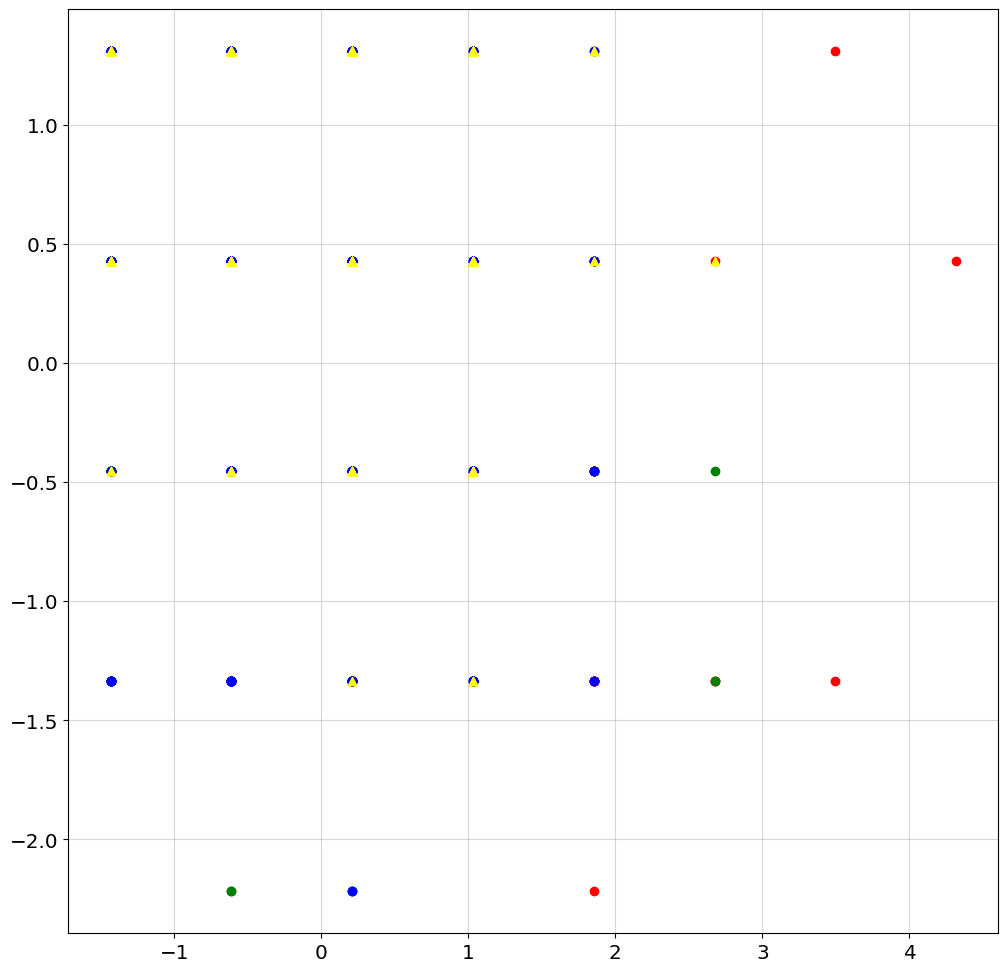

In [38]:
# CLUSTERING #

# 1. APPLY K-MEANS CLUSTERING

X = data_clean.drop('final_grade', axis=1)
y = data_clean['final_grade']

kmeans = KMeans(n_clusters=4)
label=kmeans.fit(data_clean)

# 2. ADD THE COLUMN OF THE CLUSTER (optional)
data_clean["kmeans_4"]=kmeans.labels_

# predict the labels of clusters.
label = kmeans.fit_predict(data_clean)
 
print(label)

#filter rows of original data

params = {'legend.fontsize': 'x-large','figure.figsize': (12, 12),
         'axes.labelsize': 'x-large','axes.titlesize':'x-large',
         'xtick.labelsize':'x-large','ytick.labelsize':'x-large'}
plt.rcParams.update(params)

fig, ax = plt.subplots()

filtered_label0 = data_clean[label == 0]
 
filtered_label1 = data_clean[label == 1]

filtered_label2 = data_clean[label == 2]

filtered_label3 = data_clean[label == 3]
 
#Plotting the results
plt.scatter(filtered_label0.iloc[:,0] , filtered_label0.iloc[:,1] , color = 'red')
plt.scatter(filtered_label1.iloc[:,0] , filtered_label1.iloc[:,1] , color = 'green')
plt.scatter(filtered_label2.iloc[:,0] , filtered_label2.iloc[:,1] , color = 'blue')
plt.scatter(filtered_label3.iloc[:,0] , filtered_label3.iloc[:,1] , color = 'yellow', marker='^')

plt.grid(alpha=0.5); plt.show()

Since we do not know the true clusters in this case, we cannot use this plot to visually check if the generated clusters match the true clusters. However, this plot can still be useful for exploring the structure of the data and identifying any potential patterns or separations in the data.We can see from the colors of the points that the points are not really grouped together as expected. A lot of the yellow points, with label "3" was placed rather close to each other. However, the green, blue and red points seems to have placements based on other patterns it found. 

## DBSCAN

In [39]:
Scan = DBSCAN()
temp = Scan.fit_predict(X)
print(temp)
print("\033[1m" + "We notice that everything is labeled as noice (we have to change esp and min sampels)"+ "\033[0;0m")

[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1

0.7425833481136442 12.991391054522692


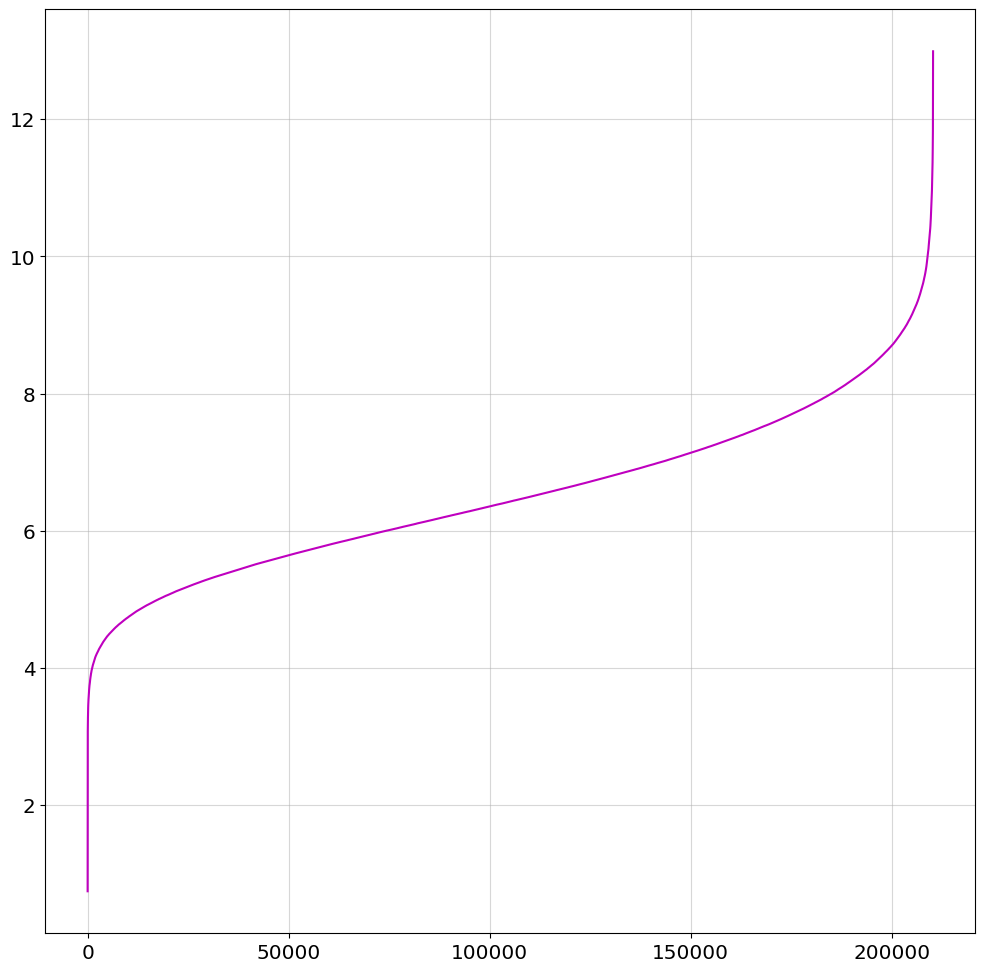

In [40]:
# Calulating the distance between all data points an using the elbow method to find the optimal eps for full dataset 
def distance_function(X=X, max_range = 649): 
    distance_arr = np.array(X)


    D = []
    for i in range(0, 649):
        j = i +1
        while j < 649:
            distances = np.linalg.norm(((distance_arr[i,:])) - np.array(distance_arr[j,:]))
            if distances != 0:    # we don't need to think about non-existent distances
                D.append(distances) 
            j += 1


    D.sort(reverse=False)
    print(str(D[0]) , str(D[-1]))

    plt.grid(alpha=0.5); plt.plot(D, color="m")
distance_function()

We can derive from the plot that the optimal esp for the whole data set is around 4.2. 

Min sampels is most often chosen from data understanding but because we lack that we wrote a functon to test for the best value for min_sampels.

In [41]:
def test_clustering(X_train=X, start=3,stop=30, eps=5.5):
  hara_score = 0.0
  ette_score = 0.0
  string1 =""
  string2=""
  for min in range(start,stop):
    clf = DBSCAN(eps=eps,min_samples=min)
    cluster = clf.fit_predict(X_train)
    try:
      cal = calinski_harabasz_score(X_train,clf.labels_)
      sil = silhouette_score(X_train,clf.labels_)
    except ValueError:
      cal=-1
      sil=-1
    if cal > hara_score:
      hara_score = cal
      string1 =" Calinski_harabasz_score for:" + str(min) + " is the highest at:" 

    if sil  > ette_score:
      ette_score = sil
      string2 =" Silhouette_score for:" + str(min) + " is the highest at:"


  print(string1)
  print(hara_score)
  print(string2)
  print(ette_score)
test_clustering(eps=4.2)

 Calinski_harabasz_score for:15 is the highest at:
33.266782933064334
 Silhouette_score for:4 is the highest at:
0.09143293660254381


Even though calinski_harabasz_score and silhouette_score often generate a lower value for density based clusters then for convex clusters our results are really low. We can try with feature selection to see if the results improve.

0.8215584799660351 9.308581540511833


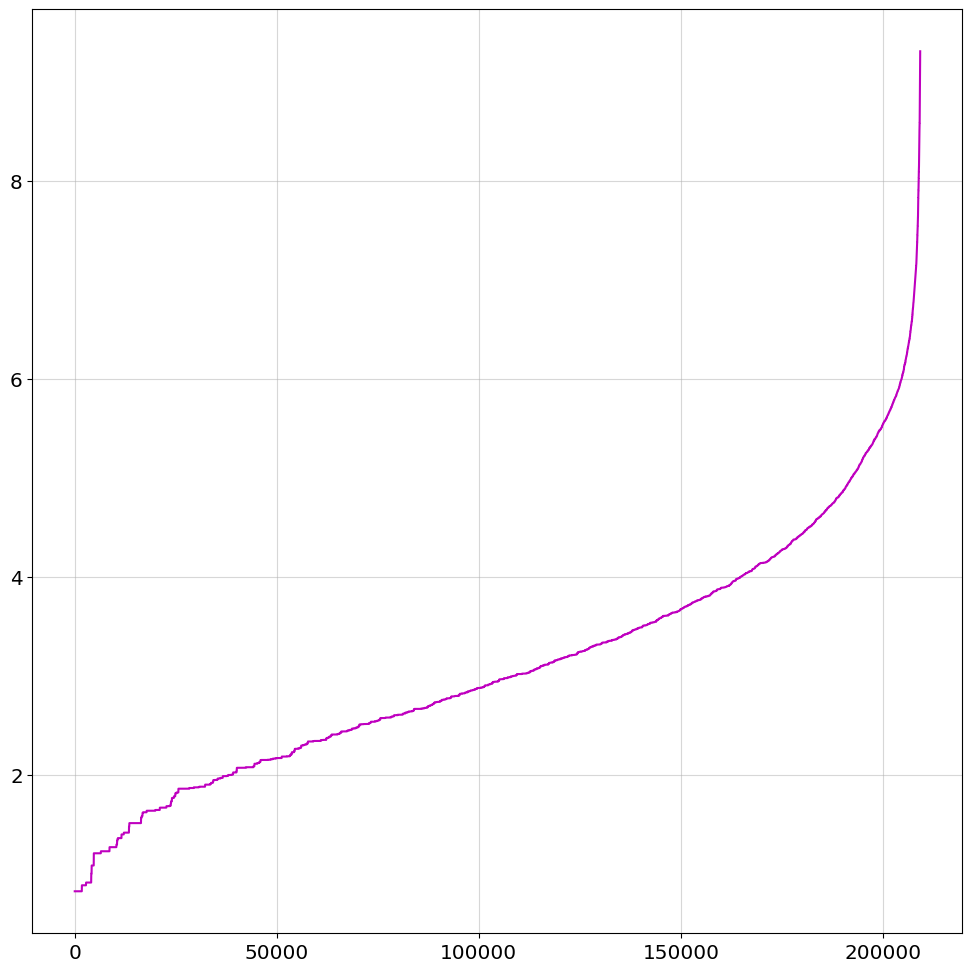

In [42]:
distance_function(X=X[list_wit_features])


In [43]:
test_clustering(X[list_wit_features],eps=1.8)

 Calinski_harabasz_score for:26 is the highest at:
131.40093768225552
 Silhouette_score for:6 is the highest at:
0.4263724604824239


In [44]:
Scan = DBSCAN(eps=1.8, min_samples=6)
cluster = Scan.fit_predict(X[list_wit_features])
print("calinski_harabasz_score:")
print(calinski_harabasz_score(X[list_wit_features],Scan.labels_))
print("silhouette_score:")
print(silhouette_score(X[list_wit_features],Scan.labels_))

calinski_harabasz_score:
105.90448080442495
silhouette_score:
0.4263724604824239


## Classification with decision trees

Before creating the classification model, we will alter the properties of the "final_grade" to have labels set to above average and below average. That means that all grade values are lower than the mean of the grades in the dataset, they will be categorized as "below_average", otherwise they will be categorized as "above_average".

In [45]:
# Multilabel sequences are considered to be continuous, while binary and multiclass types are discrete.
# Only features with discrete values can be used in the classifier.

boolean_mask = data_without_G1_G2.columns.isin(['age', 'mother_education', 'father_education', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'going_out',
       'workday_alcohol', 'weekend_alcohol', 'health', 'absences', 'school_GP', 'school_MS', 'sex_F', 'sex_M', 'address_R', 'address_U',
       'family_size_GT3', 'family_size_LE3', 'parent_cohabition_status_A', 'parent_cohabition_status_T', 'mother_job_at_home', 'mother_job_health',
       'mother_job_other', 'mother_job_services', 'mother_job_teacher', 'father_job_at_home', 'father_job_health', 'father_job_other','father_job_services', 
       'father_job_teacher', 'reason_course', 'reason_home', 'reason_other', 'reason_reputation', 'guardian_father', 'guardian_mother', 'guardian_other', 
       'school_support_yes','family_support_yes', 'paid_yes', 'extra_curricular_activities_yes', 'nursery_yes', 'higher_yes', 'internet_access_yes','romantic_yes'])
sc = data_without_G1_G2.columns[boolean_mask]

labels = ["below_average", "above_average"]

mean = data_without_G1_G2["final_grade"].mean()

conditions = [(data_without_G1_G2["final_grade"] < mean),(data_without_G1_G2["final_grade"] >= mean)]


In [46]:
# Use numpy.select to apply the labels based on the conditions
data_without_G1_G2["final_grade"] = np.select(conditions, labels, default="average") # default is set to average 

y_class = data_without_G1_G2["final_grade"]
X_class = data_without_G1_G2[sc]

print(y_class)

0      below_average
1      below_average
2      above_average
3      above_average
4      above_average
           ...      
644    below_average
645    above_average
646    below_average
647    below_average
648    below_average
Name: final_grade, Length: 649, dtype: object


In [47]:
clf = tree.DecisionTreeClassifier()   # instantiate
clf = clf.fit(X_class, y_class)   # train

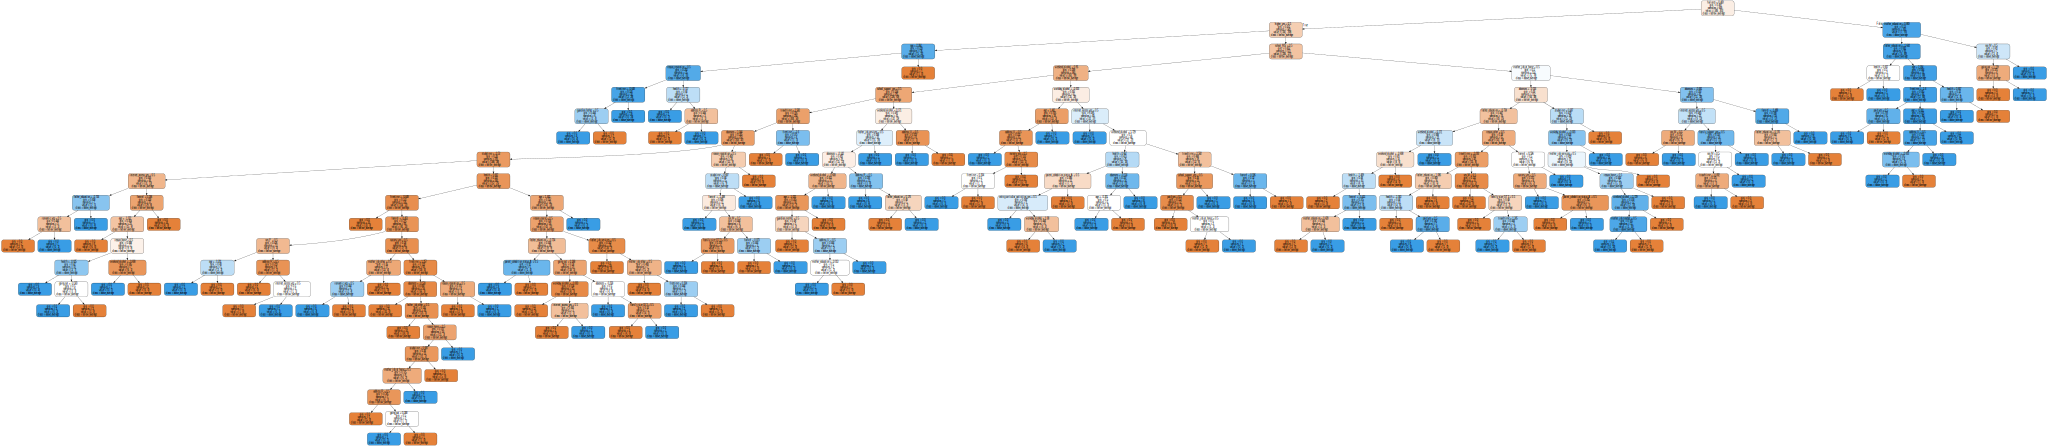

In [48]:
# MAKE A DECISION TREE #

dot_data = export_graphviz(clf, out_file=None, feature_names=sc, class_names=labels, filled=True, rounded=True, special_characters=True)
graph = graphviz.Source(dot_data)
graph.render("decision_tree")   # save the plot to a file called "decision_tree.pdf"
graph = graphviz.Source(dot_data)  
graph.format = 'png'
# graph.render('decision_tree', view=True)

graph

In [49]:
# CLASSIFICATION MODEL AND PREDICTION # 

X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_class, y_class, train_size=0.8)

clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train_class, y_train_class)

y_pred = clf.predict(X_test_class)

print("Test set preds :", y_pred)
print("Test set labels:", y_test_class)

Test set preds : ['above_average' 'above_average' 'above_average' 'below_average'
 'above_average' 'above_average' 'above_average' 'above_average'
 'below_average' 'above_average' 'above_average' 'above_average'
 'below_average' 'below_average' 'above_average' 'below_average'
 'above_average' 'above_average' 'above_average' 'above_average'
 'above_average' 'below_average' 'below_average' 'above_average'
 'below_average' 'above_average' 'below_average' 'above_average'
 'above_average' 'below_average' 'above_average' 'above_average'
 'above_average' 'below_average' 'below_average' 'below_average'
 'below_average' 'above_average' 'above_average' 'below_average'
 'above_average' 'below_average' 'above_average' 'below_average'
 'above_average' 'above_average' 'below_average' 'below_average'
 'below_average' 'below_average' 'above_average' 'above_average'
 'above_average' 'below_average' 'above_average' 'below_average'
 'below_average' 'below_average' 'above_average' 'above_average'
 'above_

In [50]:
print("According to this classification model, the most common grade group amongst students are:")
print(max(set(y_pred), key=y_pred.tolist().count))

According to this classification model, the most common grade group amongst students are:
above_average


In [51]:
# MEASURING HOW WELL THE MODEL DID #
print(classification_report(y_test_class, clf.predict(X_test_class),target_names=labels))

               precision    recall  f1-score   support

below_average       0.64      0.63      0.64        71
above_average       0.57      0.58      0.57        59

     accuracy                           0.61       130
    macro avg       0.60      0.61      0.60       130
 weighted avg       0.61      0.61      0.61       130



The precision is a measure of how many positive identifications actually were correct, which in this case is pretty alright, since the value can be interpreted as a percentage of how many "positive" identifications there was in total.

The recall is a measure of what percentage of true positives that were accurately detected and the f1-score measures the model's accuracy, as it is the harmonic mean of precision and recall. Considering these definitions, the results are quite alright, but not good enough to make a confident statement about the model's performance. 

In [52]:
# MAKING A CONFUSION MATRIX #

# This function is retrieved from a code example in Lecture 4

def print_cm(cm, labels, hide_zeroes=False, hide_diagonal=False, hide_threshold=None):
    """pretty print for confusion matrixes"""
    """taken and adapted by Bob Sturm from https://gist.github.com/zachguo/10296432"""
    columnwidth = max([len(x) for x in labels] + [5])  # 5 is value length
    empty_cell = " " * columnwidth
    
    # Begin CHANGES
    fst_empty_cell = (columnwidth-3)//2 * " " + "t\p" + (columnwidth-3)//2 * " "
    
    if len(fst_empty_cell) < len(empty_cell):
        fst_empty_cell = " " * (len(empty_cell) - len(fst_empty_cell)) + fst_empty_cell
    # Print header
    print("    " + fst_empty_cell, end=" ")
    # End CHANGES
    
    for label in labels:
        print("%{0}s".format(columnwidth) % label, end=" ")
        
    print()
    # Print rows
    for i, label1 in enumerate(labels):
        print("    %{0}s".format(columnwidth) % label1, end=" ")
        for j in range(len(labels)):
            cell = "%{0}.2f".format(columnwidth) % cm[i, j]
            if hide_zeroes:
                cell = cell if float(cm[i, j]) != 0 else empty_cell
            if hide_diagonal:
                cell = cell if i != j else empty_cell
            if hide_threshold:
                cell = cell if cm[i, j] > hide_threshold else empty_cell
            print(cell, end=" ")
        print()

        
confusion = metrics.confusion_matrix(y_test_class, y_pred)   
print_cm(confusion,labels)

         t\p      below_average above_average 
    below_average         45.00         26.00 
    above_average         25.00         34.00 


The main diagonal tells us that the number of True positives as well as the number of True negatives, and the other values are the confusions. The classifier got most of the labels correct, but way too many incorrect. Especially now that the final grade feature only have the labels "below average" and "above average". This is not good enough to be able to make a confident statement from the model.

In cells below, further feature selection are performed, specifically for the classifier.

In [53]:
# FEATURE SELECTION WITH SELECT K BEST #

# Number of features chosen will be 8.

selector = SelectKBest(score_func=mutual_info_classif, k=10)  
selector.fit(X_train_class, y_train_class)

selected_features = X_class.columns[selector.get_support()]

print("Selected features:", selected_features)

Selected features: Index(['father_education', 'failures', 'workday_alcohol', 'school_GP',
       'school_MS', 'address_R', 'family_size_GT3', 'family_support_yes',
       'higher_yes', 'internet_access_yes'],
      dtype='object')


In [54]:
boolean_mask = data_without_G1_G2.columns.isin(selected_features.tolist())
sc = data_without_G1_G2.columns[boolean_mask]
X = data_without_G1_G2[sc]

boolean_mask_target = data_without_G1_G2.columns.isin(["final_grade"])
s = data_without_G1_G2.columns[boolean_mask_target]
y = data_without_G1_G2[s]

In [55]:
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_class, y_class, train_size=0.8)

clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train_class, y_train_class)

y_pred = clf.predict(X_test_class)

print("Test set preds :", y_pred)
print("Test set labels:", y_test_class)

Test set preds : ['below_average' 'above_average' 'above_average' 'below_average'
 'above_average' 'below_average' 'above_average' 'above_average'
 'above_average' 'above_average' 'above_average' 'below_average'
 'above_average' 'below_average' 'above_average' 'below_average'
 'above_average' 'above_average' 'below_average' 'above_average'
 'above_average' 'above_average' 'below_average' 'below_average'
 'above_average' 'above_average' 'below_average' 'above_average'
 'above_average' 'above_average' 'below_average' 'above_average'
 'below_average' 'below_average' 'above_average' 'below_average'
 'below_average' 'below_average' 'below_average' 'above_average'
 'above_average' 'above_average' 'below_average' 'below_average'
 'below_average' 'above_average' 'below_average' 'above_average'
 'above_average' 'above_average' 'above_average' 'below_average'
 'above_average' 'above_average' 'above_average' 'above_average'
 'below_average' 'above_average' 'above_average' 'below_average'
 'above_

In [56]:
print(classification_report(y_test_class, clf.predict(X_test_class),target_names=labels))

               precision    recall  f1-score   support

below_average       0.62      0.74      0.67        61
above_average       0.72      0.59      0.65        69

     accuracy                           0.66       130
    macro avg       0.67      0.67      0.66       130
 weighted avg       0.67      0.66      0.66       130



In [57]:
confusion = metrics.confusion_matrix(y_test_class, y_pred)   
print_cm(confusion,labels)

         t\p      below_average above_average 
    below_average         45.00         16.00 
    above_average         28.00         41.00 


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f34834cf-eefb-4b4e-9d3a-8921fcff33b1' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>